# Documentation

## EDA – Executive Summary
- **Raw data:** 1,000 rows, 11 columns. Target `Trip_Price` is missing in 49 rows → kept separately for inference examples.
- **Key features:** Trip_Distance_km, Trip_Duration_Minutes, Base_Fare, Per_Km_Rate, Per_Minute_Rate; categorical: Time_of_Day, Day_of_Week, Traffic_Conditions, Weather.
- **Cleaning:** dropped duplicates; filtered negative values; capped `Trip_Price` at the 99th percentile; median imputation for numeric, mode for categoricals.
- **Engineered features:** Rule_Estimate, Diff_to_Rule, Km_per_Min.
- **Modeling takeaway:** Data supports a tree-based regressor with One-Hot on categorical features; see baseline metrics in training logs.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, platform
import sklearn

print(f"Python", sys.version.split()[0], " | OS:", platform.system(), platform.release())
print(f"Pandas: {pd.__version__} | Numpy: {np.__version__} | Sklearn: {sklearn.__version__}")

Python 3.12.3  | OS: Windows 10
Pandas: 2.2.3 | Numpy: 2.2.5 | Sklearn: 1.7.2


## Data dictionary (compact)

In [26]:
raw_path = "../data/raw/taxi_trip_pricing.csv"
df = pd.read_csv(raw_path)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

def summarize(df):
    rows = []
    for c in df.columns:
        s = df[c]
        row = {
            "column": c, "dtype": str(s.dtype),
            "nulls": int(s.isna().sum()), "null_%": round(100*s.isna().mean(), 2)        
        }
        if c in num_cols:
            row |= {
                "min": float(s.min(skipna=True)) if s.notna().any() else None,
                "mean": float(s.mean(skipna=True)) if s.notna().any() else None,
                "max": float(s.max(skipna=True)) if s.notna().any() else None,
            }
        else:
            row |= {
                "unique": int(s.nunique(dropna=True)),
                "top": (s.value_counts(dropna=True).index[:1].tolist()[0] if s.notna().any() else None),
            }
        rows.append(row)
    return pd.DataFrame(rows).sort_values(["null_%", "column"], ascending=[False, True])

profile = summarize(df)
profile

,column,dtype,nulls,null_%,min,mean,max,unique,top
6,Base_Fare,float64,50,5.0,2.0100,3.502989,5.000000,NaN,NaN
2,Day_of_Week,object,50,5.0,NaN,NaN,NaN,2.0,Weekday
3,Passenger_Count,float64,50,5.0,1.0000,2.476842,4.000000,NaN,NaN
7,Per_Km_Rate,float64,50,5.0,0.5000,1.233316,2.000000,NaN,NaN
8,Per_Minute_Rate,float64,50,5.0,0.1000,0.292916,0.500000,NaN,NaN
1,Time_of_Day,object,50,5.0,NaN,NaN,NaN,4.0,Afternoon
4,Traffic_Conditions,object,50,5.0,NaN,NaN,NaN,3.0,Low
0,Trip_Distance_km,float64,50,5.0,1.2300,27.070547,146.067047,NaN,NaN
9,Trip_Duration_Minutes,float64,50,5.0,5.0100,62.118116,119.840000,NaN,NaN
5,Weather,object,50,5.0,NaN,NaN,NaN,3.0,Clear


### Duplicates

In [21]:
dups = df.duplicated().sum()
print(f"duplicates: {dups}")

duplicates: 0


## Plots

### Trip Price -histogram & boxplot

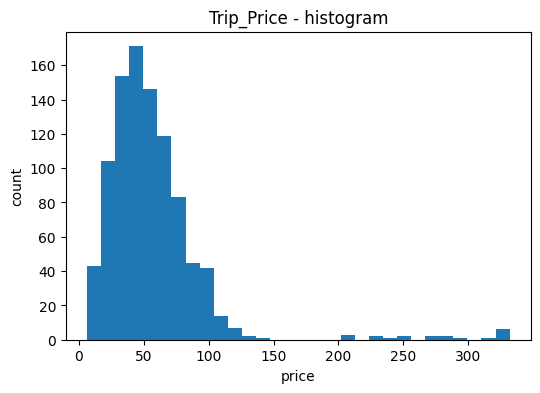

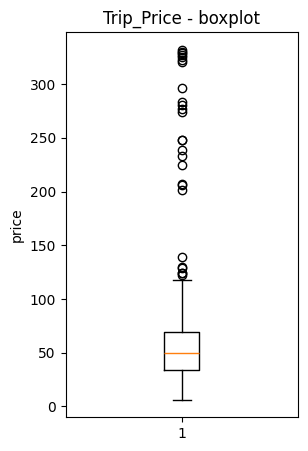

In [5]:
col_price = "Trip_Price"
plt.figure(figsize=(6, 4)); plt.hist(df[col_price].dropna(), bins=30); plt.title("Trip_Price - histogram"); plt.xlabel("price"); plt.ylabel("count"); plt.show()
plt.figure(figsize=(3, 5)); plt.boxplot(df[col_price].dropna(), vert=True); plt.title("Trip_Price - boxplot"); plt.ylabel("price"); plt.show()

### Trip distance & duration - histogram

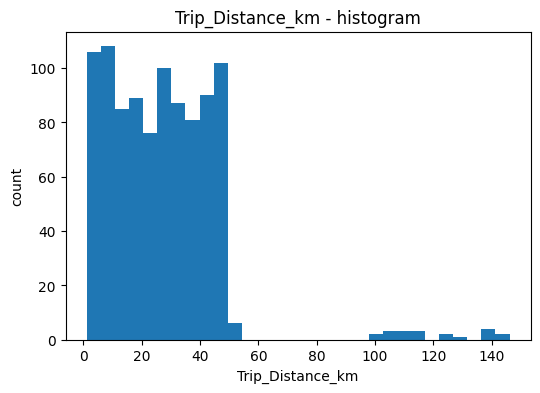

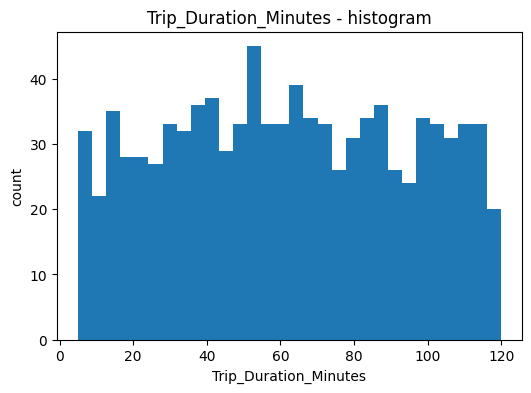

In [24]:
for c in ["Trip_Distance_km", "Trip_Duration_Minutes"]:
    if c in df.columns:
        plt.figure(figsize=(6, 4))
        plt.hist(df[c].dropna(), bins=30)
        plt.title(f"{c} - histogram")
        plt.xlabel(c); plt.ylabel("count"); plt.show()

### Correlation heatmap

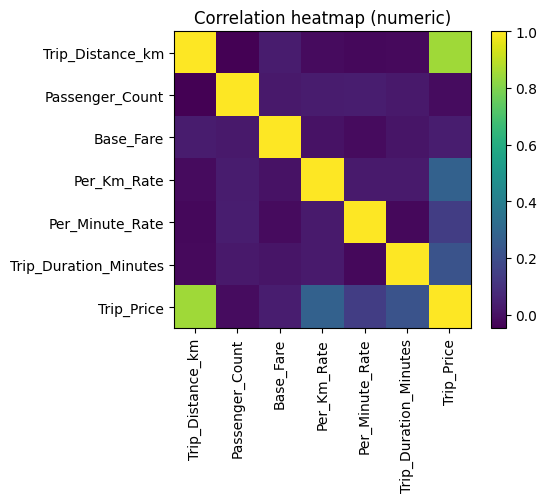

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
Trip_Distance_km,1.00,-0.05,0.03,-0.02,-0.03,-0.02,0.85
Passenger_Count,-0.05,1.00,0.02,0.03,0.03,0.02,-0.01
Base_Fare,0.03,0.02,1.00,0.00,-0.02,0.01,0.04
Per_Km_Rate,-0.02,0.03,0.00,1.00,0.03,0.03,0.28
Per_Minute_Rate,-0.03,0.03,-0.02,0.03,1.00,-0.02,0.14
Trip_Duration_Minutes,-0.02,0.02,0.01,0.03,-0.02,1.00,0.22
Trip_Price,0.85,-0.01,0.04,0.28,0.14,0.22,1.00


In [18]:
num = df.select_dtypes(include=[np.number])
corr = num.corr(numeric_only=True)
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, interpolation="nearest")
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation heatmap (numeric)")
plt.tight_layout(); plt.show()
corr.round(2)

### Raw vs Clean comparison

Raw: (1000, 11)  | Clean: (941, 11)


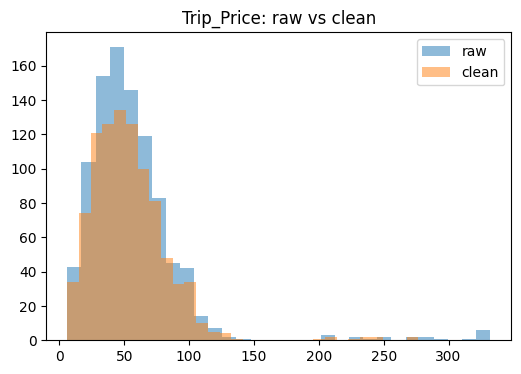

In [20]:
df_clean = pd.read_csv("../data/processed/taxi_clean.csv")
print ("Raw:", df.shape, " | Clean:", df_clean.shape)

plt.figure(figsize=(6, 4))
plt.hist(df["Trip_Price"].dropna(), bins=30, alpha=0.5, label="raw")
plt.hist(df_clean["Trip_Price"].dropna(), bins=30, alpha=0.5, label="clean")
plt.title("Trip_Price: raw vs clean"); plt.legend(); plt.show()

### Decisions & Assumptions
- **Missing values:** median imputation for numeric; mode for categorical features.
- **Outliers:** `Trip_Price` winsorized at the 99th percentile; additionally capped extreme `Trip_Distance_km` / `Trip_Duration_Minutes` at high quantiles.
- **Sanity filters:** removed negative distance/duration/price; dropped duplicates.
- **Engineered features:** `Rule_Estimate` (base + per-km + per-min), `Diff_to_Rule`, `Km_per_Min`.
- **Scope limits:** no geospatial features or holiday effects available in this dataset.